In [7]:
import os
import torch
import torchvision
import zipfile
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


image_size = 64
batch_size = 128

In [9]:
data_dir = './dogscats'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['valid', 'test1', 'sample', 'train']
['dogs', 'cats']


In [10]:
dogs_train = os.listdir(data_dir + "/train/dogs")
print('No. of training examples for dogs:', len(dogs_train))

cats_train = os.listdir(data_dir + "/train/cats")
print('No. of training examples for cats:', len(cats_train))

dogs_val = os.listdir(data_dir + "/valid/dogs")
print('No. of val examples for dogs:', len(dogs_val))

cats_val = os.listdir(data_dir + "/valid/cats")
print('No. of val examples for cats:', len(cats_val))

No. of training examples for dogs: 11500
No. of training examples for cats: 11500
No. of val examples for dogs: 1000
No. of val examples for cats: 1000


In [11]:
train_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
val_dataset = ImageFolder(data_dir+'/valid', transform=ToTensor())

In [12]:
train_dataset = ImageFolder(data_dir + '/train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

val_dataset = ImageFolder(data_dir + '/valid', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

In [13]:
img, label = val_dataset[2]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.6392, 0.5765, 0.5020,  ..., 0.6941, 0.6784, 0.6706],
         [0.4824, 0.5098, 0.6392,  ..., 0.6667, 0.6118, 0.5922],
         [0.4471, 0.6078, 0.6863,  ..., 0.6431, 0.4392, 0.3765],
         ...,
         [0.3333, 0.3216, 0.3373,  ..., 0.6784, 0.7294, 0.6902],
         [0.3647, 0.3608, 0.3490,  ..., 0.7569, 0.6824, 0.6157],
         [0.3725, 0.3569, 0.3686,  ..., 0.6275, 0.5333, 0.5529]],

        [[0.5333, 0.4627, 0.4000,  ..., 0.6510, 0.6235, 0.6157],
         [0.2863, 0.3098, 0.4902,  ..., 0.6235, 0.5843, 0.5686],
         [0.2667, 0.4549, 0.6000,  ..., 0.6078, 0.4588, 0.3961],
         ...,
         [0.3137, 0.3020, 0.3137,  ..., 0.6353, 0.6471, 0.6118],
         [0.3333, 0.3294, 0.3255,  ..., 0.6980, 0.6353, 0.5765],
         [0.3412, 0.3255, 0.3412,  ..., 0.6314, 0.5804, 0.5686]],

        [[0.3843, 0.3176, 0.2902,  ..., 0.4745, 0.4431, 0.4196],
         [0.3333, 0.2745, 0.3451,  ..., 0.4392, 0.4157, 0.4039],
         [0.3373, 0.3490, 0.3961,  ..., 0.4314, 0.3686, 0.

In [14]:
print(train_dataset.classes)

['cats', 'dogs']


In [16]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  cats (0)


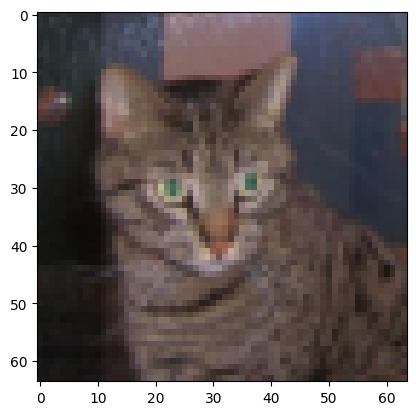

In [17]:
show_example(*train_dataset[1])

Label:  cats (0)


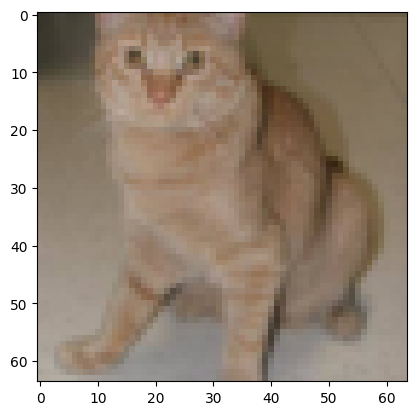

In [19]:
show_example(*train_dataset[1079])

In [20]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

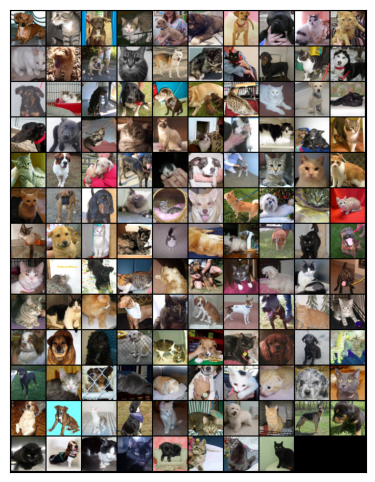

In [22]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

[](http://)Using the ResNet models from torchvision.models

In [24]:
class DogsCatsCnnModelResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [25]:
class DogsCatsCnnModelResNet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [26]:
class DogsCatsCnnModelResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [27]:
class DogsCatsCnnModelResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [29]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [31]:
class DogsCatsCnnModelResNet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [32]:
model_resnet_18 = DogsCatsCnnModelResNet18()
model_resnet_34 = DogsCatsCnnModelResNet34()
model_resnet_50 = DogsCatsCnnModelResNet50()
model_resnet_101 = DogsCatsCnnModelResNet101()
model_resnet_152 = DogsCatsCnnModelResNet152()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/pradhammummaleti/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 230M/230M [03:25<00:00, 1.17MB/s]


In [33]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

## Training the Model

We can define `fit` and `evaluate` functions to train our model.

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
print(evaluate(model_resnet_18, val_dl))
print(evaluate(model_resnet_34, val_dl))
print(evaluate(model_resnet_50, val_dl))
print(evaluate(model_resnet_101, val_dl))
print(evaluate(model_resnet_152, val_dl))

{'val_loss': 0.7020546197891235, 'val_acc': 0.46950119733810425}
{'val_loss': 0.7034303545951843, 'val_acc': 0.49590593576431274}
{'val_loss': 0.686182975769043, 'val_acc': 0.5714768767356873}
{'val_loss': 0.7169621586799622, 'val_acc': 0.49049729108810425}
{'val_loss': 0.7031608819961548, 'val_acc': 0.4892578125}


In [36]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [37]:
history0 = fit(num_epochs, lr, model_resnet_18, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4488, val_loss: 0.4436, val_acc: 0.8663
Epoch [1], train_loss: 0.4187, val_loss: 0.5089, val_acc: 0.7977
Epoch [2], train_loss: 0.3998, val_loss: 0.4354, val_acc: 0.8708
Epoch [3], train_loss: 0.3921, val_loss: 0.4102, val_acc: 0.8989
Epoch [4], train_loss: 0.3852, val_loss: 0.4302, val_acc: 0.8776


In [38]:
torch.save(model_resnet_18.state_dict(), 'dogscats-cnn-resnet18.pth')

In [39]:
history1 = fit(num_epochs, lr, model_resnet_34, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4572, val_loss: 0.4172, val_acc: 0.8897


KeyboardInterrupt: 

In [ ]:
torch.save(model_resnet_34.state_dict(), 'dogscats-cnn-resnet34.pth')

In [ ]:
history2 = fit(num_epochs, lr, model_resnet_50, train_dl, val_dl, opt_func)

In [ ]:
torch.save(model_resnet_50.state_dict(), 'dogscats-cnn-resnet50.pth')

In [ ]:
history3 = fit(num_epochs, lr, model_resnet_101, train_dl, val_dl, opt_func)

In [ ]:
torch.save(model_resnet_101.state_dict(), 'dogscats-cnn-resnet101.pth')

In [ ]:
history4 = fit(num_epochs, lr, model_resnet_152, train_dl, val_dl, opt_func)

In [ ]:
torch.save(model_resnet_152.state_dict(), 'dogscats-cnn-resnet152.pth')

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

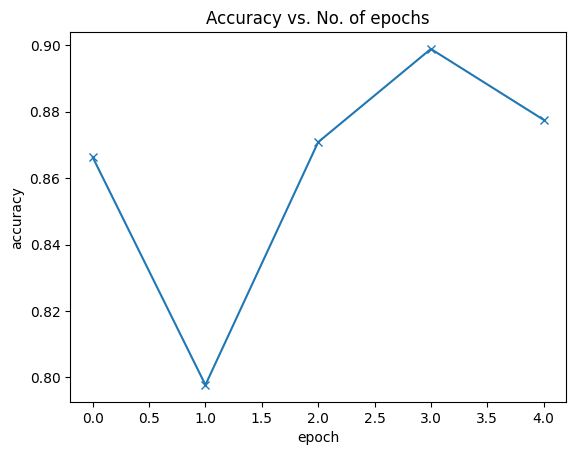

In [41]:
plot_accuracies(history0)
# plot_accuracies(history1)
# plot_accuracies(history2)
# plot_accuracies(history3)
# plot_accuracies(history4)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

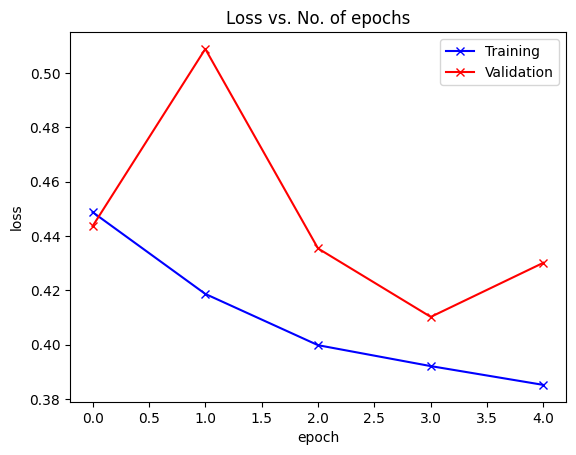

In [43]:
plot_losses(history0)
# plot_losses(history1)
# plot_losses(history2)
# plot_losses(history3)
# plot_losses(history4)